In [197]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torchvision

In [198]:
# hyper-params
MODEL_PATH = ""
input_size = 512
# input_size = (360, 567)
IN_SCALE = 1024/input_size 
MODEL_SCALE = 4
batch_size = 2
model_name = 'resnet18'
TRAIN = True

In [199]:
DIR_INPUT = './ht-peaks-dataset'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.head()

,Unnamed: 0,image_id,x,y
0,0,1l_1n-1,249.0,384.0
1,0,1l_1n-2,359.0,284.0
2,0,1l_1n-3,21.0,439.0
3,0,1l_1n-4,77.0,477.0
4,0,1l_1n-5,132.0,444.0


In [200]:
# split train-test
from sklearn.model_selection import train_test_split

# split by unique image ids
image_ids = train_df['image_id'].unique()
train_id, test_id = train_test_split(image_ids, test_size=0.2, random_state=777)


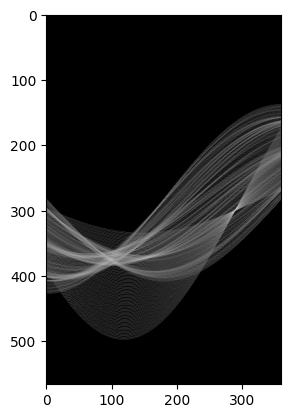

In [201]:
img_id = train_id[0]
img = cv2.imread(os.path.join(DIR_INPUT, "train", img_id+"-ht.png"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

   Unnamed: 0 image_id      x      y
8           0  1l_1n-9  289.0  301.0


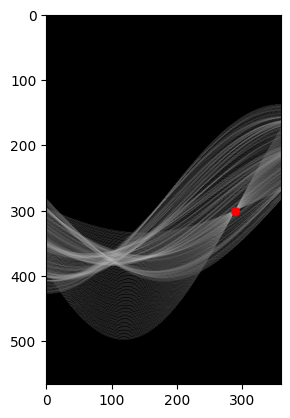

In [202]:
# plot centers on image
target = train_df[train_df['image_id']==img_id]
print(target)
plt.imshow(img)
plt.scatter(target['x'], target['y'], color='red', s=30)


In [203]:
# make heatmaps using the utility functions from the centernet repo
def draw_msra_gaussian(heatmap, center, sigma=2):
    tmp_size = sigma * 6
    mu_x = int(center[0] + 0.5)
    mu_y = int(center[1] + 0.5)
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = 2 * tmp_size + 1
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
    g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    return heatmap

In [204]:
def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1, -n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h


In [205]:
def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
    value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)
    dim = value.shape[0]
    reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value
    if is_offset and dim == 2:
        delta = np.arange(diameter*2+1) - radius
        reg[0] = reg[0] - delta.reshape(1, -1)
        reg[1] = reg[1] - delta.reshape(-1, 1)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
    masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom,
                               radius - left:radius + right]
    masked_reg = reg[:, radius - top:radius + bottom,
                     radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0:  # TODO debug
        idx = (masked_gaussian >= masked_heatmap).reshape(
            1, masked_gaussian.shape[0], masked_gaussian.shape[1])
        masked_regmap = (1-idx) * masked_regmap + idx * masked_reg
    regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap
    return regmap


In [206]:
# Wrapped heatmap function
def make_hm_regr(target):
    # make output heatmap for single class
    hm = np.zeros([input_size//MODEL_SCALE, input_size//MODEL_SCALE])
    # make regr heatmap
    regr = np.zeros([2, input_size//MODEL_SCALE, input_size//MODEL_SCALE])

    if len(target) == 0:
        return hm, regr

    center = np.array([target['x'], target['y']]).T
    
    # make a center point
    # try gaussian points.
    for c in center:
        hm = draw_msra_gaussian(hm, [int(c[0])//MODEL_SCALE//IN_SCALE, int(c[1])//MODEL_SCALE//IN_SCALE],
                                sigma=np.clip(10*10//2, 2, 4))

    # convert targets to its center.
    regrs = center[:, 2:]/input_size/IN_SCALE

    # plot regr values to mask
    for r, c in zip(regrs, center):
        for i in range(-2, 3):
            for j in range(-2, 3):
                try:
                    regr[:, int(c[0])//MODEL_SCALE//IN_SCALE+i,
                         int(c[1])//MODEL_SCALE//IN_SCALE+j] = r
                except:
                    pass
    return hm, regr


In [207]:
def pred2box(hm, regr, thresh=0.99):
    # make binding box from heatmaps
    # thresh: threshold for logits.

    # get center
    pred = hm > thresh
    pred_center = np.where(hm > thresh)
    # get regressions
    pred_r = regr[:, pred].T

    # wrap as boxes
    # [xmin, ymin, width, height]
    # size as original image.
    boxes = []
    scores = hm[pred]
    for i, b in enumerate(pred_r):
        arr = np.array([pred_center[1][i]*MODEL_SCALE-b[0]*input_size//2, pred_center[0][i]*MODEL_SCALE-b[1]*input_size//2, 
                      int(b[0]*input_size), int(b[1]*input_size)])
        arr = np.clip(arr, 0, input_size)
        # filter
        # if arr[0]<0 or arr[1]<0 or arr[0]>input_size or arr[1]>input_size:
        # pass
        boxes.append(arr)
    return np.asarray(boxes), scores


In [208]:
# functions for plotting results
def showbox(img, hm, regr, thresh=0.9):
    boxes, _ = pred2box(hm, regr, thresh=thresh)
    print("preds:", boxes.shape)
    print('box', boxes)
    sample = img

    for box in boxes:
        # upper-left, lower-right
        cv2.rectangle(sample,
                      (int(box[0]), int(box[1]+10)),
                      (int(box[0]+10), int(box[1])),
                      (220, 0, 0), 3)
    return sample


def showgtbox(img, hm, regr, thresh=0.9):
    boxes, _ = pred2box(hm, regr, thresh=thresh)
    print("GT boxes:", boxes.shape)
    sample = img

    for box in boxes:
        cv2.rectangle(sample,
                      (int(box[0]), int(box[1]+box[3])),
                      (int(box[0]+box[2]), int(box[1])),
                      (0, 220, 0), 3)
    return sample


preds: (1, 4)
box [[144. 148.   0.   0.]]


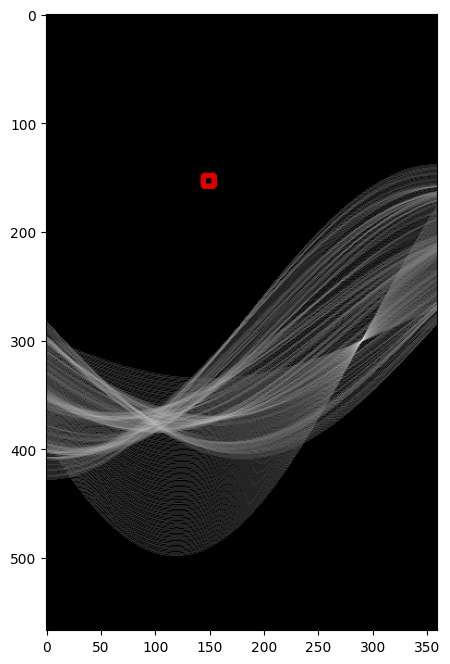

In [209]:
# convert target to heatmaps
hm, regr = make_hm_regr(target)

# get boxes
boxes, _ = pred2box(hm, regr)

fig, ax = plt.subplots(1, 1, figsize=(16,8))
sample = showbox(img, hm, regr, 0.99)
plt.imshow(sample)
plt.show()

In [210]:
from torchvision import transforms

class Normalize(object):
    def __init__(self):
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.norm = transforms.Normalize(self.mean, self.std)
    def __call__(self, image):
        image = image.astype(np.float32)/255
        axis = (0,1)
        image -= self.mean
        image /= self.std
        return image


# pool duplicates
def pool(data):
    stride = 3
    for y in np.arange(1, data.shape[1]-1, stride):
        for x in np.arange(1, data.shape[0]-1, stride):
            a_2d = data[x-1:x+2, y-1:y+2]
            max = np.asarray(np.unravel_index(np.argmax(a_2d), a_2d.shape))
            for c1 in range(3):
                for c2 in range(3):
                    # print(c1,c2)
                    if not (c1 == max[0] and c2 == max[1]):
                        data[x+c1-1, y+c2-1] = -1
    return data


class WheatDataset(torch.utils.data.Dataset):
    def __init__(self, img_id, labels, transform=None):
        self.img_id = img_id
        self.labels = labels
        if transform:
            self.transform = transform
        self.normalize = Normalize()

    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(
            DIR_INPUT, "train", self.img_id[idx]+"-ht.png"))
        img = cv2.resize(img, (input_size, input_size))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        target = self.labels[self.labels['image_id'] == self.img_id[idx]]
        hm, regr = make_hm_regr(target)
        return img, hm, regr


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


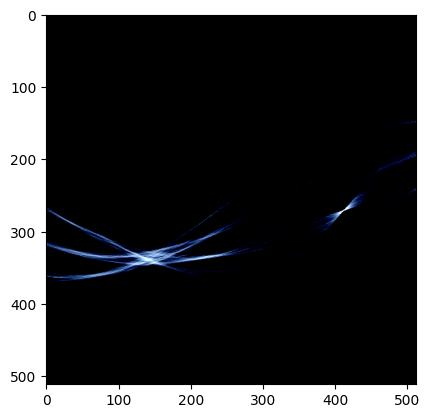

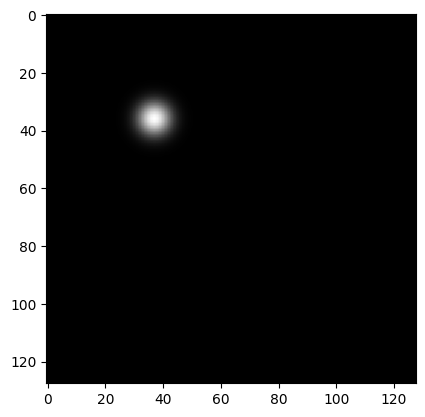

In [211]:
traindataset = WheatDataset(train_id, train_df)
valdataset = WheatDataset(test_id, train_df)

img, hm, regr = traindataset[0]

plt.imshow(img.transpose([1,2,0]))
plt.show()
plt.imshow(hm.T, cmap='gray')

In [212]:
# Pack to dataloaders
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=True, num_workers=0)

In [213]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
            # input is CHW
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]

            x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                            diffY // 2, diffY - diffY//2))
        else:
            x = x1
        x = self.conv(x)
        return x


class centernet(nn.Module):
    def __init__(self, n_classes=1, model_name="resnet18"):
        super(centernet, self).__init__()
        # create backbone.
        basemodel = torchvision.models.resnet18(
            pretrained=False)  # turn this on for training
        basemodel = nn.Sequential(*list(basemodel.children())[:-2])
        # set basemodel
        self.base_model = basemodel

        if model_name == "resnet34" or model_name == "resnet18":
            num_ch = 512
        else:
            num_ch = 2048

        self.up1 = up(num_ch, 512)
        self.up2 = up(512, 256)
        self.up3 = up(256, 256)
        # output classification
        self.outc = nn.Conv2d(256, n_classes, 1)
        # output residue
        self.outr = nn.Conv2d(256, 2, 1)

    def forward(self, x):
        batch_size = x.shape[0]

        x = self.base_model(x)

        # Add positional info
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        outc = self.outc(x)
        outr = self.outr(x)
        return outc, outr


In [214]:
model = centernet()
# Check if it runs correctly
model(torch.rand(1,3,512,512))[0].size()

/home/lmceschini/Documents/ufrgs/fvc/ht-peaks-detection/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lmceschini/Documents/ufrgs/fvc/ht-peaks-detection/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([1, 1, 128, 128])

In [215]:
# Gets the GPU if there is one, otherwise the cpu
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [216]:
# From centernet repo
def neg_loss(pred, gt):
  ''' Modified focal loss. Exactly the same as CornerNet.
      Runs faster and costs a little bit more memory
    Arguments:
      pred (batch x c x h x w)
      gt_regr (batch x c x h x w)
  '''
  pred = pred.unsqueeze(1).float()
  gt = gt.unsqueeze(1).float()

  pos_inds = gt.eq(1).float()
  neg_inds = gt.lt(1).float()
  neg_weights = torch.pow(1 - gt, 4)

  loss = 0

  pos_loss = torch.log(pred + 1e-12) * torch.pow(1 - pred, 3) * pos_inds
  neg_loss = torch.log(1 - pred + 1e-12) * torch.pow(pred, 3) * neg_weights * neg_inds

  num_pos  = pos_inds.float().sum()
  pos_loss = pos_loss.sum()
  neg_loss = neg_loss.sum()

  if num_pos == 0:
    loss = loss - neg_loss
  else:
    loss = loss - (pos_loss + neg_loss) / num_pos
  return loss

def _reg_loss(regr, gt_regr, mask):
  ''' L1 regression loss
    Arguments:
      regr (batch x max_objects x dim)
      gt_regr (batch x max_objects x dim)
      mask (batch x max_objects)
  '''
  num = mask.float().sum()
  #print(gt_regr.size())
  mask = mask.sum(1).unsqueeze(1).expand_as(gt_regr)
  #print(mask.size())

  regr = regr * mask
  gt_regr = gt_regr * mask
    
  regr_loss = nn.functional.smooth_l1_loss(regr, gt_regr, size_average=False)
  regr_loss = regr_loss / (num + 1e-4)
  return regr_loss
  
def centerloss(prediction, mask, regr,weight=0.4, size_average=True):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
    mask_loss = neg_loss(pred_mask, mask)
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
  
    # Sum
    loss = mask_loss +regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss ,mask_loss , regr_loss

In [217]:
def train(epoch):
    model.train()
    print('epochs {}/{} '.format(epoch+1, epochs))
    running_loss = 0.0
    running_mask = 0.0
    running_regr = 0.0
    t = tqdm(train_loader)
    rd = np.random.rand()

    for idx, (img, hm, regr) in enumerate(t):
        # send to gpu
        img = img.type(torch.FloatTensor)
        img = img.to(device)
        hm_gt = hm.to(device)
        regr_gt = regr.to(device)
        # set opt
        optimizer.zero_grad()

        # run model
        # hm, regr = model(img.permute(0, 3, 1, 2))
        hm, regr = model(img)
        preds = torch.cat((hm, regr), 1)

        loss, mask_loss, regr_loss = centerloss(preds, hm_gt, regr_gt)
        # misc
        running_loss += loss
        running_mask += mask_loss
        running_regr += regr_loss

        loss.backward()
        optimizer.step()

        t.set_description(
            f't (l={running_loss/(idx+1):.3f})(m={running_mask/(idx+1):.4f})(r={running_regr/(idx+1):.4f})')

    # scheduler.step()
    print('train loss : {:.4f}'.format(running_loss/len(train_loader)))
    print('maskloss : {:.4f}'.format(running_mask/(len(train_loader))))
    print('regrloss : {:.4f}'.format(running_regr/(len(train_loader))))

    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                 'loss': running_loss/len(train_loader), "mask": running_mask/(len(train_loader)),
                 "regr": running_regr/(len(train_loader))}
    logs.append(log_epoch)


In [218]:
# epochs=100
epochs = 5
logs = []
logs_eval = []

if TRAIN:
    for epoch in range(epochs):
        train(epoch)
else:
    model.load_state_dict(torch.load(MODEL_PATH))


epochs 1/5 


/tmp/ipykernel_42717/560532563.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/4 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 1.95 GiB total capacity; 1004.75 MiB already allocated; 1.12 MiB free; 1.02 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF